## goal:

* improve performance and change point detection: reduce false detection and improve performance for difficult data
* use cluster result to assigna probabilities to segments of power usage.


In [1]:
# load a few necessary packages

%matplotlib inline

import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
    

In [10]:
# repeat calculation in 3.3 in the last notebook

def extract_first_n(data_list, n):
    return [t[:n] for t in data_list if len(t)>=n]

def evolve_prob(prior_prob, r_list, retain_prob):
    new_prob = []
    for t in prior_prob:
        new_prob.append([retain_prob[r]+p for p, r in zip(t, r_list)])
    return new_prob

# print evolve_prob([[-1, -2],[-3, -4]], [2,4], [1,2,3,4,5])

def sum_prob(prob):
    return sp.misc.logsumexp(prob)
# print sum_prob([[1,2], [3,4]]), sum_prob([1,2,3,4])
# print sum_prob([1,2]), np.log(np.sum(np.exp(1)+np.exp(2)))

def add_to_all(list_of_list, val):
    res = []
    for l in list_of_list:
        res.append([x+val for x in l])
    return res
# print add_to_all([[1,2],[3,4,5]],2)

def add_to_front(new_front, list_of_list):
    return [[new_front]+t for t in list_of_list]
# print add_to_front(1, [[2],[3,4],[]])

# np.argmax(prior_list), prior_list, r_list
# a = [[1,2,33],[4,5,12]]
# np.argmax(a)
def get_max_id(list_of_list):
    n_list = len(list_of_list)
    list_size = len(list_of_list[0])
    t = np.argmax(list_of_list)+1
    i_list = np.ceil(t / float(list_size)) - 1
    pos_in_list = t - i_list * list_size - 1
#     print 'n_list', n_list
#     print 'list_size', list_size
#     print 't', t
#     print 'i_list', i_list
#     print 'pos_in_list', pos_in_list
    return int(i_list), int(pos_in_list)
# get_max_id(a)

def select_from_list(list_of_list, id):
    result = []
    for l in list_of_list:
        result.append([l[i] for i in id])
    return result
# print select_from_list([[1,2,3], [3,4,5], [2,3,4,6]], [0,2])

def create_counter(mem=100):
    return {'mem':mem, 'dat':[0 for i in range(mem)],'start':0}

def vote(obj, counter, pos, p):
    while obj['start'] < counter - obj['mem'] + 1:
        obj['dat'].pop(0)
        obj['dat'].append(0)
        obj['start'] += 1
    if pos-obj['start']>=0:
        obj['dat'][pos-obj['start']]+=p
    return obj
    
def search_call(obj, thre):
    return [pos+obj['start'] for pos, p in enumerate(obj['dat']) if p > thre]

def rel_change(y):
    return np.min([np.abs(y[1] - y[0]), np.abs(y[1] - y[2])]) / float(y[1])

def rel_change_filter(t, data_input, thre=.2):
    id_filter = [i for i in range(1, len(data_input)-1) 
     if (data_input[i]>data_input[i-1] and data_input[i]>data_input[i+1] and rel_change(data_input[i-1:i+2])>thre) or
                 (data_input[i]<data_input[i-1] and data_input[i]<data_input[i+1] and rel_change(data_input[i-1:i+2])>thre/(1-thre))
    ]
    id_filter2 = np.setdiff1d(range(len(data_input)), id_filter)
    t_2 = [t[i] for i in id_filter2]
    data_input_2 = [data_input[i] for i in id_filter2]
    return t_2, data_input_2

def update_prob(datum, prior_prob, r_list, mu_list, sigma_list, shapes, mu_prior, sigma_measurement):
    n_shape = len(shapes) # the number of possible change points
    n_r = len(r_list) # the number of r(s), r is the distance to the last change point
    shape_len = len(shapes[0])
    flag_print = False
    if flag_print:
        print 'shape_len', shape_len
        print 'datum', datum
        print 'mu_prior (last point)', mu_prior
#     if len(r_list) != n_shape:
#         raise('the number of r list does not match to the number of shapes')
    if len(prior_prob) != n_shape:
        raise('the number of prior prob does not match to the number of shapes')
    for t in prior_prob:
        if len(t) != n_r:
            print len(t), n_r
            raise('number of r does not match to probs')
    for t in mu_list:
        if len(t) != n_r:
            raise('number of r does not match to mu')
    for t in sigma_list:
        if len(t) != n_r:
            raise('number of r does not match to sigma')
    
    TOL = .9999
    
    gap_prior = 100.
    min_length_prior = 5
    STORAGE_MAX = 10000 # at a cost of mem, make a look up table for log H and log 1-H
    log_H_list = [np.log(1-1/(gap_prior*100))] * min_length_prior + [np.log(1-1/gap_prior)]*(STORAGE_MAX-min_length_prior) # hazard function, log(1-H)
    log_H_2_list = [np.log(1/(gap_prior*100))] * min_length_prior + [np.log(1/gap_prior)]*(STORAGE_MAX-min_length_prior) # log(H)
    
    if flag_print:
        print 'prior_prob', prior_prob
        print 'r_list', r_list
        print 'mu_list', mu_list
        print 'sigma_list', sigma_list

    # step 1, calculate the new probabilty of prior_prob, considering part of 
    # the possibility will go to new change point
    prior_prob_plus_1 = evolve_prob(prior_prob, r_list, log_H_list)
    prob_change = np.log((1-np.exp(sum_prob(prior_prob_plus_1)))/n_shape)
    prob_update = [[prob_change]+t for t in prior_prob_plus_1]
    if flag_print:
        print 'step 1'
        print prob_update, sum_prob(prob_update)
    
    # step 2: update r_list
    r_list_update = [0] + [t+1 for t in r_list]
    if flag_print:
        print 'step 2'
        print 'r_list_update', r_list_update
    
    # step 3: update u and sigma
    mu_prior = mu_prior
    sigma_prior = 50
    mu_list_update = add_to_front(mu_prior, mu_list)
    sigma_list_update = add_to_front(sigma_prior, sigma_list)
    if flag_print:
        print 'step 3'
        print 'mu_list_update', mu_list_update
        print 'sigma_list_update', sigma_list_update
    
    # step 4: predict prob
    mu_list_post = []
    sigma_list_post = []
    prob_list_post = []
    for i_shape in range(n_shape):
        mu_list_post_tmp = []
        sigma_list_post_tmp = []
        prob_list_post_tmp = []
        for i_r in range(n_r+1): # because everything shifted by 1
            r = r_list_update[i_r]
            mu = mu_list_update[i_shape][i_r]
            sigma = sigma_list_update[i_shape][i_r]
            if r < shape_len:
                shape_value = shapes[i_shape][r]
            else:
                shape_value = shapes[i_shape][-1]
            mu_with_shift = mu + shape_value
            # update sigma and mu, note that mu is considered as shift
            mu_update_with_shift = (mu_with_shift*sigma_measurement**2+datum*sigma**2)/(sigma_measurement**2+sigma**2)
            mu_update = mu_update_with_shift-shape_value
            sigma_update = np.sqrt(sigma_measurement**2*sigma**2/(sigma_measurement**2+sigma**2))
            
            prob = prob_update[i_shape][i_r]
            predict_prob = -((datum-mu_with_shift)/sigma_measurement)**2/2.0-np.log(sigma_measurement) 
            prob_post = prob + predict_prob
            
            if flag_print:
                print i_shape, i_r, 'r:', r, 'mu', mu, 'sigma', sigma, 'mu_with_shift', mu_with_shift
                print 'datum', datum, 
                print 'mu_update_with_shift', mu_update_with_shift, 'mu_update', mu_update, 'sigma_update', sigma_update
                print 'prob', prob, 'predict_prob', predict_prob, 'prob_post', prob_post
            mu_list_post_tmp.append(mu_update)
            sigma_list_post_tmp.append(sigma_update)
            prob_list_post_tmp.append(prob_post)
        mu_list_post.append(mu_list_post_tmp)
        sigma_list_post.append(sigma_list_post_tmp)
        prob_list_post.append(prob_list_post_tmp)
    
    # truncation
    t = sum_prob(prob_list_post)
    prob_list_post = add_to_all(prob_list_post, -t)

    # test if truncation is possible
    cum_pro = np.cumsum( np.sum(np.exp(prob_list_post),axis=0) )
    i_r_max = np.min([i for i, pro in enumerate(cum_pro) if pro > TOL]);
    if flag_print:
        print 'current r_max', r_list_update[i_r_max]
    if i_r_max<10:
        if flag_print:
            print 'i_r_max too small, do not truncate'
        i_r_max = len(cum_pro)-1

    if flag_print:
        print 'cum_pro', cum_pro
        print 'mu_list_post', mu_list_post
        print 'sigma_list_post', sigma_list_post
        print 'prob_list_post', prob_list_post, sum_prob(prob_list_post)
        print 'r_list_update', r_list_update

    mu_list_post = extract_first_n(mu_list_post, i_r_max+1)
    sigma_list_post = extract_first_n(sigma_list_post, i_r_max+1)
    prob_list_post = extract_first_n(prob_list_post, i_r_max+1)
    r_list_update = [t for i, t in enumerate(r_list_update) if i <=i_r_max]
    if flag_print:
        print 'total r(s)', len(cum_pro), 'truncation', i_r_max
        
    # a second round of truncation for flat signals, truncate from the end
    if len(r_list_update) > 30:
        r_max = np.max(r_list_update)
        valid_r = [i for i,t in enumerate(r_list_update) if t < 30 or t >= r_max-30]
        mu_list_post = select_from_list(mu_list_post, valid_r)
        sigma_list_post = select_from_list(sigma_list_post, valid_r)
        prob_list_post = select_from_list(prob_list_post, valid_r)
        r_list_update = [r_list_update[i] for i in valid_r]
#         r_list_update = [t for i, t in enumerate(r_list_update) if i <=i_r_max]
        
    
    # find the highest p
    i_shape_ml, i_r_ml = get_max_id(prob_list_post)
#     print len(prob_list_post[0]), len(r_list_update), i_shape_ml, i_r_ml, np.array(prob_list_post).shape
#     print prob_list_post
    if flag_print:
        print 'best prob is shape %d and dist to the last cp is %d' % (i_shape_ml, r_list_update[i_r_ml])
        
    if flag_print:
        print 'mu_list_post', mu_list_post
        print 'sigma_list_post', sigma_list_post
        print 'prob_list_post', prob_list_post, sum_prob(prob_list_post)
        print 'r_list_update', r_list_update
    r_list_update[i_r_ml]
    return prob_list_post, mu_list_post, sigma_list_post, r_list_update, (i_shape_ml, r_list_update[i_r_ml], np.max(prob_list_post))

def disaggregate_with_shape(t, y, shapes):
    sigma_init = 20

    t, y = rel_change_filter(t, y, thre=.2)
    n_shapes = len(shapes)

    r_list = [0]
    prior_list = [[np.log(1./n_shapes)]] * n_shapes
    mu_list = [[0]] * n_shapes
    sigma_list =[[sigma_init]] * n_shapes

    # print r_list
    # print prior_list
    # print mu_list
    # print sigma_list

    last_y = 100
    sigma_measurement = 20
    cp_results = []
    cp_counter = create_counter()
    all_cp = []
    r_list_len = []
    counter_max = 800
    for counter in range(len(y)):
        prior_list, mu_list, sigma_list, r_list, most_likely_cp = update_prob(y[counter], prior_list, r_list, mu_list, sigma_list, shapes, last_y, sigma_measurement)
        vote(cp_counter, counter, counter-most_likely_cp[1], np.exp(most_likely_cp[2]))
        cp = search_call(cp_counter, 1)
        all_cp.extend(cp)
        all_cp = list(set(all_cp))
        cp_results.append(most_likely_cp)
        r_list_len.append(len(r_list))

        last_y = y[counter]

    all_cp = np.sort(all_cp)
    return t, y, all_cp

In [3]:
# prepare example data
from bayesian_cp_detect import file_readef

def load_dat(date, Hstart, Hend, folder='data/IHG/'):
    (t,y)=np.array(file_readef.readfile(date,Hstart,Hend,folder))
    return t, y

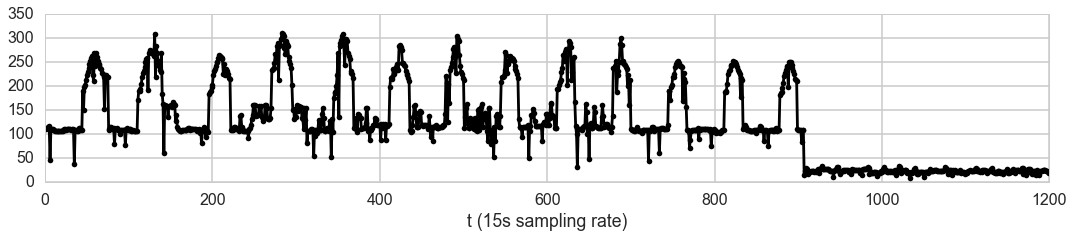

In [4]:
# example data, should be easy to disaggregate
# plot the example data

t_raw_4_16_19_23, y_raw_4_16_19_23 = load_dat('4-16', 19, 23, 'data/IHG/')

plt.figure(figsize=[18,3])
plt.plot(t_raw_4_16_19_23, y_raw_4_16_19_23, 'k.-')
plt.xlabel('t (15s sampling rate)')

In [5]:
# write a function overlay change points to raw data
def plot_with_cp(y, cp_list=[]):
    plt.figure(figsize=(18,3))
    plt.plot(y, 'k-', linewidth=2)
    for cp in cp_list:
        plt.plot([cp,cp], [0, 500], 'k--', linewidth=1)
    plt.xlabel('t')
    plt.ylabel('power')

In [508]:
import json

with open('metadata/april data.json', 'r') as fid:
    var_t = json.load(fid)
    all_seg_april = var_t[0]
    all_seg_2_april = var_t[1]
    cluster_mean_sort = var_t[2]
    cluster_std_sort = var_t[3]

CPU times: user 2.87 s, sys: 119 ms, total: 2.99 s
Wall time: 2.91 s


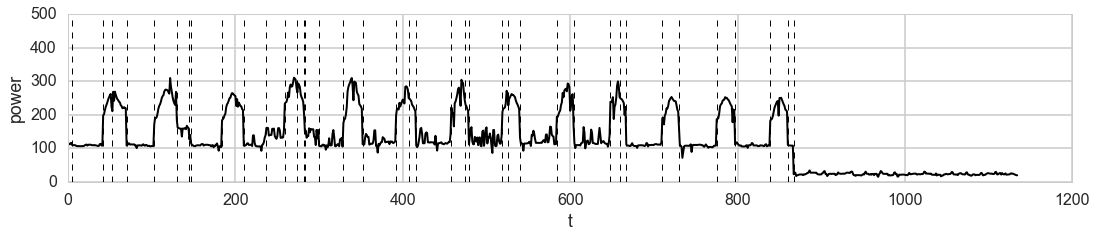

In [11]:
%%time
shapes = [cluster_mean_sort[i] for i in range(6) if i != 2]
t, y, cp = disaggregate_with_shape(t_raw_4_16_19_23, y_raw_4_16_19_23, shapes)
plot_with_cp(y,cp)

** new version to disaggregate with shape, output intermedia result also **

In [403]:
def update_prob_0812(datum, prior_prob, r_list, mu_list, sigma_list, shapes, mu_prior, sigma_measurement,
                    flag_print = True):
    '''
    version update, store all intermediate into a result dict
    '''
    n_shape = len(shapes) # the number of possible change points
    n_r = len(r_list) # the number of r(s), r is the distance to the last change point
    shape_len = len(shapes[0])

    result_dict = {}
    
    if flag_print:
        result_dict['shape_len'] = shape_len
        result_dict['datum'] = datum
        result_dict['mu_prior'] = mu_prior
#     if len(r_list) != n_shape:
#         raise('the number of r list does not match to the number of shapes')
    if len(prior_prob) != n_shape:
        raise('the number of prior prob does not match to the number of shapes')
    for t in prior_prob:
        if len(t) != n_r:
            print len(t), n_r
            raise('number of r does not match to probs')
    for t in mu_list:
        if len(t) != n_r:
            raise('number of r does not match to mu')
    for t in sigma_list:
        if len(t) != n_r:
            raise('number of r does not match to sigma')
    
    TOL = .9999
    
    gap_prior = 100.
    min_length_prior = 5
    STORAGE_MAX = 10000 # at a cost of mem, make a look up table for log H and log 1-H
    log_H_list = [np.log(1-1/(gap_prior*100))] * min_length_prior + [np.log(1-1/gap_prior)]*(STORAGE_MAX-min_length_prior) # hazard function, log(1-H)
    log_H_2_list = [np.log(1/(gap_prior*100))] * min_length_prior + [np.log(1/gap_prior)]*(STORAGE_MAX-min_length_prior) # log(H)
    
    if flag_print:
        result_dict['prior_prob'] = prior_prob
        result_dict['r_list'] = r_list
        result_dict['mu_list'] = mu_list
        result_dict['sigma_list'] = sigma_list
        
    # step 1, calculate the new probabilty of prior_prob, considering part of 
    # the possibility will go to new change point
    prior_prob_plus_1 = evolve_prob(prior_prob, r_list, log_H_list)
    prob_change = np.log((1-np.exp(sum_prob(prior_prob_plus_1)))/n_shape)
    prob_update = [[prob_change]+t for t in prior_prob_plus_1]
    if flag_print:
        result_dict['prob_update'] = prob_update
    
    # step 2: update r_list
    r_list_update = [0] + [t+1 for t in r_list]
    if flag_print:
        result_dict['r_list_update'] = r_list_update
    
    # step 3: update u and sigma
    mu_prior = mu_prior
    sigma_prior = 50
    mu_list_update = add_to_front(mu_prior, mu_list)
    sigma_list_update = add_to_front(sigma_prior, sigma_list)
    if flag_print:
        result_dict['mu_list_update'] = mu_list_update
        result_dict['sigma_list_update'] = sigma_list_update
    
    # step 4: predict prob
    mu_list_post = []
    sigma_list_post = []
    prob_list_post = []
    for i_shape in range(n_shape):
        mu_list_post_tmp = []
        sigma_list_post_tmp = []
        prob_list_post_tmp = []
        for i_r in range(n_r+1): # because everything shifted by 1
            r = r_list_update[i_r]
            mu = mu_list_update[i_shape][i_r]
            sigma = sigma_list_update[i_shape][i_r]
            if r < shape_len:
                shape_value = shapes[i_shape][r]
            else:
                shape_value = shapes[i_shape][-1]
            mu_with_shift = mu + shape_value
            # update sigma and mu, note that mu is considered as shift
            mu_update_with_shift = (mu_with_shift*sigma_measurement**2+datum*sigma**2)/(sigma_measurement**2+sigma**2)
            mu_update = mu_update_with_shift-shape_value
            sigma_update = np.sqrt(sigma_measurement**2*sigma**2/(sigma_measurement**2+sigma**2))
            
            prob = prob_update[i_shape][i_r]
            predict_prob = -((datum-mu_with_shift)/sigma_measurement)**2/2.0-np.log(sigma_measurement) 
            prob_post = prob + predict_prob
            
            if flag_print:
                if 'update_para' not in result_dict:
                    result_dict['update_para'] = []
                result_dict['update_para'].append({'i_shape':i_shape, 'i_r':i_r, 
                                    'mu': mu, 'sigma': sigma, 'mu_with_shift': mu_with_shift, 
                                    'mu_update_with_shift': mu_update_with_shift, 'mu_update': mu_update, 'sigma_update': sigma_update, 
                                    'prob': prob, 'predict_prob': predict_prob, 'prob_post': prob_post
                                   })
            mu_list_post_tmp.append(mu_update)
            sigma_list_post_tmp.append(sigma_update)
            prob_list_post_tmp.append(prob_post)
        mu_list_post.append(mu_list_post_tmp)
        sigma_list_post.append(sigma_list_post_tmp)
        prob_list_post.append(prob_list_post_tmp)
    
    # truncation
    t = sum_prob(prob_list_post)
    prob_list_post = add_to_all(prob_list_post, -t)

    # test if truncation is possible
    cum_pro = np.cumsum( np.sum(np.exp(prob_list_post),axis=0) )
    i_r_max = np.min([i for i, pro in enumerate(cum_pro) if pro > TOL]);
    if flag_print:
        result_dict['current r_max'] = r_list_update[i_r_max]
        result_dict['i_r_max'] = i_r_max
        
    if i_r_max<10:
        i_r_max = len(cum_pro)-1

    if flag_print:
        result_dict['cum_pro'] = cum_pro
        result_dict['mu_list_post'] = mu_list_post
        result_dict['sigma_list_post'] = sigma_list_post
        result_dict['prob_list_post'] = prob_list_post
        result_dict['r_list_update'] = r_list_update
        
    mu_list_post = extract_first_n(mu_list_post, i_r_max+1)
    sigma_list_post = extract_first_n(sigma_list_post, i_r_max+1)
    prob_list_post = extract_first_n(prob_list_post, i_r_max+1)
    r_list_update = [t for i, t in enumerate(r_list_update) if i <=i_r_max]
    if flag_print:
        result_dict['i_r_max'] = i_r_max
        result_dict['total r'] = len(cum_pro)
        
    # a second round of truncation for flat signals, truncate from the end
    if len(r_list_update) > 30:
        r_max = np.max(r_list_update)
        valid_r = [i for i,t in enumerate(r_list_update) if t < 30 or t >= r_max-30]
        mu_list_post = select_from_list(mu_list_post, valid_r)
        sigma_list_post = select_from_list(sigma_list_post, valid_r)
        prob_list_post = select_from_list(prob_list_post, valid_r)
        r_list_update = [r_list_update[i] for i in valid_r]
        
    # find the highest p
    i_shape_ml, i_r_ml = get_max_id(prob_list_post)
    if flag_print:
        result_dict['i_shape_ml'] = i_shape_ml
        result_dict['best_r'] = r_list_update[i_r_ml]
        
    if flag_print:
        result_dict['mu_list_post'] = mu_list_post
        result_dict['sigma_list_post'] = sigma_list_post
        result_dict['prob_list_post'] = prob_list_post
        result_dict['r_list_update'] = r_list_update
    r_list_update[i_r_ml]
    return prob_list_post, mu_list_post, sigma_list_post, r_list_update, (i_shape_ml, r_list_update[i_r_ml], np.max(prob_list_post)), result_dict

def disaggregate_with_shape_0812(t, y, shapes, t_range=[0,-1]):
    sigma_init = 20

    t, y = rel_change_filter(t, y, thre=.2)
    n_shapes = len(shapes)

    r_list = [0]
    prior_list = [[np.log(1./n_shapes)]] * n_shapes
    mu_list = [[0]] * n_shapes
    sigma_list =[[sigma_init]] * n_shapes

    # print r_list
    # print prior_list
    # print mu_list
    # print sigma_list

    last_y = 100
    sigma_measurement = 20
    cp_results = []
    cp_counter = create_counter()
    all_cp = []
    r_list_len = []
    
    result_dict_all = {}
    
    for counter in range(len(y)):
        prior_list, mu_list, sigma_list, r_list, most_likely_cp, result_dict = update_prob_0812(y[counter], prior_list, r_list, mu_list, sigma_list, shapes, last_y, sigma_measurement)
        vote(cp_counter, counter, counter-most_likely_cp[1], np.exp(most_likely_cp[2]))
        cp = search_call(cp_counter, 1)
        all_cp.extend(cp)
        all_cp = list(set(all_cp))
        cp_results.append(most_likely_cp)
        r_list_len.append(len(r_list))

        last_y = y[counter]
        
        if counter >= t_range[0] and counter <= t_range[1]:
            result_dict_all[counter] = result_dict

    all_cp = np.sort(all_cp)
    return t, y, all_cp, result_dict_all

CPU times: user 3.82 s, sys: 63.1 ms, total: 3.88 s
Wall time: 3.96 s


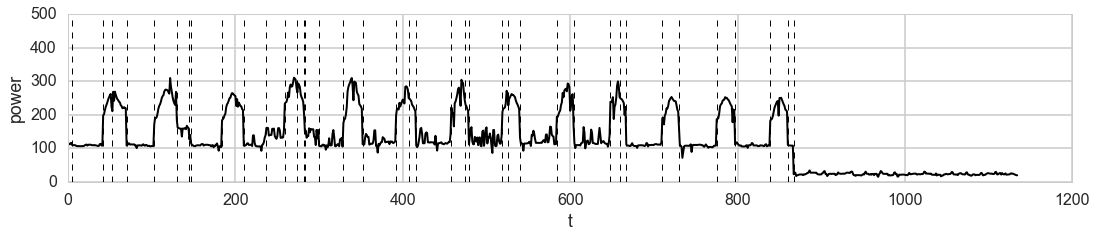

In [404]:
%%time
shapes = [cluster_mean_sort[i] for i in range(6) if i != 2]
t, y, cp, result_dict_all = disaggregate_with_shape_0812(t_raw_4_16_19_23, y_raw_4_16_19_23, shapes, [0, 70])
plot_with_cp(y,cp)

(40, 75)

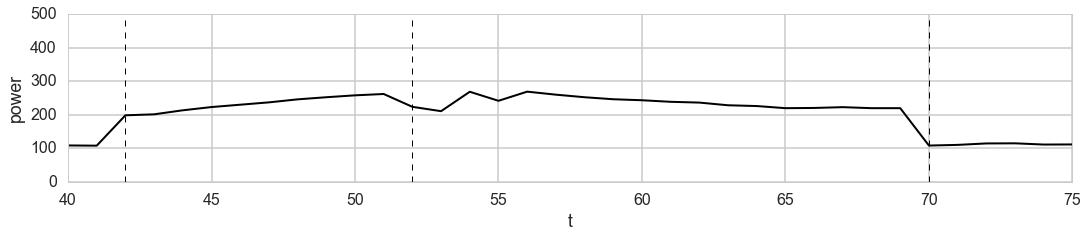

In [405]:
plot_with_cp(y,cp)
plt.xlim([40,75])

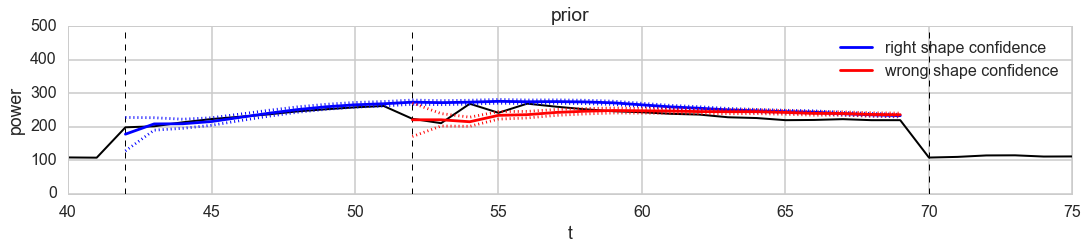

In [406]:
plot_with_cp(y,cp)
plt.xlim([40,75])
plt.plot(range(42, 70), [shapes[1][x-42]+result_dict_all[x]['mu_list_update'][1][x-42] for x in range(42, 70)], 'b', label='right shape confidence')
plt.plot(range(42, 70), [shapes[1][x-42]+result_dict_all[x]['mu_list_update'][1][x-42]+result_dict_all[x]['sigma_list_update'][1][x-42] for x in range(42, 70)],':b')
plt.plot(range(42, 70), [shapes[1][x-42]+result_dict_all[x]['mu_list_update'][1][x-42]-result_dict_all[x]['sigma_list_update'][1][x-42] for x in range(42, 70)],':b')

plt.plot(range(52, 70), [shapes[2][x-52]+result_dict_all[x]['mu_list_update'][2][x-52] for x in range(52, 70)],'r',label='wrong shape confidence')
plt.plot(range(52, 70), [shapes[2][x-52]+result_dict_all[x]['mu_list_update'][2][x-52]+result_dict_all[x]['sigma_list_update'][2][x-52] for x in range(52, 70)], 'r:')
plt.plot(range(52, 70), [shapes[2][x-52]+result_dict_all[x]['mu_list_update'][2][x-52]-result_dict_all[x]['sigma_list_update'][2][x-52] for x in range(52, 70)], 'r:')
plt.legend(loc=1)
plt.title('prior')

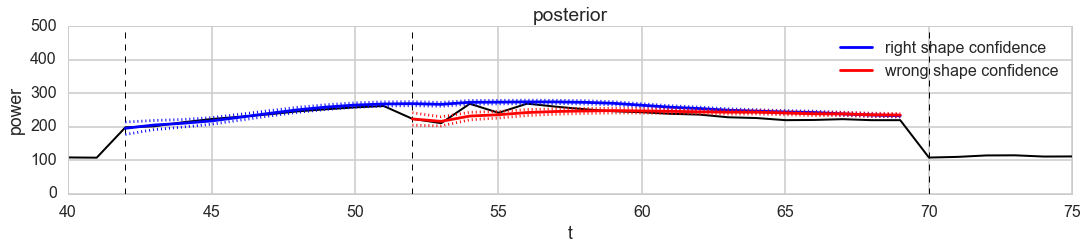

In [407]:
plot_with_cp(y,cp)
plt.xlim([40,75])
plt.plot(range(42, 70), [shapes[1][x-42]+result_dict_all[x]['mu_list_post'][1][x-42] for x in range(42, 70)], 'b', label='right shape confidence')
plt.plot(range(42, 70), [shapes[1][x-42]+result_dict_all[x]['mu_list_post'][1][x-42]+result_dict_all[x]['sigma_list_post'][1][x-42] for x in range(42, 70)],':b')
plt.plot(range(42, 70), [shapes[1][x-42]+result_dict_all[x]['mu_list_post'][1][x-42]-result_dict_all[x]['sigma_list_post'][1][x-42] for x in range(42, 70)],':b')
plt.plot(range(52, 70), [shapes[2][x-52]+result_dict_all[x]['mu_list_post'][2][x-52] for x in range(52, 70)],'r',label='wrong shape confidence')
plt.plot(range(52, 70), [shapes[2][x-52]+result_dict_all[x]['mu_list_post'][2][x-52]+result_dict_all[x]['sigma_list_post'][2][x-52] for x in range(52, 70)], 'r:')
plt.plot(range(52, 70), [shapes[2][x-52]+result_dict_all[x]['mu_list_post'][2][x-52]-result_dict_all[x]['sigma_list_post'][2][x-52] for x in range(52, 70)], 'r:')
plt.legend(loc=1)
plt.title('posterior')

** two problems here **

* the correct shape did not trace the shift fast enough. This can be solved by 1) trust data more, i.e. prior less; 2) use larger measurement noise, so that the right shape is not too unlikely

* remove wrong shape..., let the minimal down shift larger

** use larger measurement noise to update prior **

In [445]:
def update_prob_0813(datum, prior_prob, r_list, mu_list, sigma_list, shapes, mu_prior, sigma_measurement, 
                     shape_std_list, flag_print = True):
    '''
    version update, store all intermediate into a result dict
    set minimal sigma, now sigma also consider variation in shape
    '''
    
    sigma_update_min = 20
    
    n_shape = len(shapes) # the number of possible change points
    n_r = len(r_list) # the number of r(s), r is the distance to the last change point
    shape_len = len(shapes[0])

    
    result_dict = {}
    
    if flag_print:
        result_dict['shape_len'] = shape_len
        result_dict['datum'] = datum
        result_dict['mu_prior'] = mu_prior
#     if len(r_list) != n_shape:
#         raise('the number of r list does not match to the number of shapes')
    if len(prior_prob) != n_shape:
        raise('the number of prior prob does not match to the number of shapes')
    for t in prior_prob:
        if len(t) != n_r:
            print len(t), n_r
            raise('number of r does not match to probs')
    for t in mu_list:
        if len(t) != n_r:
            raise('number of r does not match to mu')
    for t in sigma_list:
        if len(t) != n_r:
            raise('number of r does not match to sigma')
    
    TOL = .9999
    
    gap_prior = 100.
    min_length_prior = 5
    STORAGE_MAX = 10000 # at a cost of mem, make a look up table for log H and log 1-H
    log_H_list = [np.log(1-1/(gap_prior*100))] * min_length_prior + [np.log(1-1/gap_prior)]*(STORAGE_MAX-min_length_prior) # hazard function, log(1-H)
    log_H_2_list = [np.log(1/(gap_prior*100))] * min_length_prior + [np.log(1/gap_prior)]*(STORAGE_MAX-min_length_prior) # log(H)
    
    if flag_print:
        result_dict['prior_prob'] = prior_prob
        result_dict['r_list'] = r_list
        result_dict['mu_list'] = mu_list
        result_dict['sigma_list'] = sigma_list
        
    # step 1, calculate the new probabilty of prior_prob, considering part of 
    # the possibility will go to new change point
    prior_prob_plus_1 = evolve_prob(prior_prob, r_list, log_H_list)
    prob_change = np.log((1-np.exp(sum_prob(prior_prob_plus_1)))/n_shape)
    prob_update = [[prob_change]+t for t in prior_prob_plus_1]
    if flag_print:
        result_dict['prob_update'] = prob_update
    
    # step 2: update r_list
    r_list_update = [0] + [t+1 for t in r_list]
    if flag_print:
        result_dict['r_list_update'] = r_list_update
    
    # step 3: update u and sigma
    mu_prior = mu_prior
    sigma_prior = 50
    mu_list_update = add_to_front(mu_prior, mu_list)
    sigma_list_update = add_to_front(sigma_prior, sigma_list)
    if flag_print:
        result_dict['mu_list_update'] = mu_list_update
        result_dict['sigma_list_update'] = sigma_list_update
    
    # step 4: predict prob
    mu_list_post = []
    sigma_list_post = []
    prob_list_post = []
    for i_shape in range(n_shape):
        mu_list_post_tmp = []
        sigma_list_post_tmp = []
        prob_list_post_tmp = []
        for i_r in range(n_r+1): # because everything shifted by 1
            r = r_list_update[i_r]
            mu = mu_list_update[i_shape][i_r]
            sigma = sigma_list_update[i_shape][i_r]
            if r < shape_len:
                shape_value = shapes[i_shape][r]
                shape_std = shape_std_list[i_shape][r]
            else:
                shape_value = shapes[i_shape][-1]
                shape_std = shape_std_list[i_shape][-1]
            mu_with_shift = mu + shape_value

            # get measurement error 
            sigma_measurement_2 = np.sqrt( sigma_measurement**2 + shape_std**2 )
            
            # update sigma and mu, note that mu is considered as shift
            mu_update_with_shift = (mu_with_shift*sigma_measurement_2**2+datum*sigma**2)/(sigma_measurement_2**2+sigma**2)
            mu_update = mu_update_with_shift-shape_value
            sigma_update = np.sqrt(sigma_measurement_2**2*sigma**2/(sigma_measurement_2**2+sigma**2))
            sigma_update = sigma_update if sigma_update > sigma_update_min else sigma_update_min
            
            prob = prob_update[i_shape][i_r]
            predict_prob = -((datum-mu_with_shift)/sigma_measurement_2)**2/2.0-np.log(sigma_measurement_2) 
            prob_post = prob + predict_prob
            
            if flag_print:
                if 'update_para' not in result_dict:
                    result_dict['update_para'] = []
                result_dict['update_para'].append({'i_shape':i_shape, 'i_r':i_r, 
                                    'mu': mu, 'sigma': sigma, 'mu_with_shift': mu_with_shift, 
                                    'mu_update_with_shift': mu_update_with_shift, 'mu_update': mu_update, 'sigma_update': sigma_update, 
                                    'prob': prob, 'predict_prob': predict_prob, 'prob_post': prob_post, 
                                    'shape_std': shape_std, 'shape_value': shape_value, 'sigma_measurement_2': sigma_measurement_2
                                   })
            mu_list_post_tmp.append(mu_update)
            sigma_list_post_tmp.append(sigma_update)
            prob_list_post_tmp.append(prob_post)
        mu_list_post.append(mu_list_post_tmp)
        sigma_list_post.append(sigma_list_post_tmp)
        prob_list_post.append(prob_list_post_tmp)
    
    if flag_print:
        result_dict['prob_list_post_after_update'] = prob_list_post

    # truncation
    t = sum_prob(prob_list_post)
    prob_list_post = add_to_all(prob_list_post, -t)
    
    if flag_print:
        result_dict['prob_list_post_after_normalization'] = prob_list_post

    # test if truncation is possible
    cum_pro = np.cumsum( np.sum(np.exp(prob_list_post),axis=0) )
    i_r_max = np.min([i for i, pro in enumerate(cum_pro) if pro > TOL]);
    if flag_print:
        result_dict['current r_max'] = r_list_update[i_r_max]
        result_dict['i_r_max'] = i_r_max
        
    if i_r_max<10:
        i_r_max = len(cum_pro)-1

#     if flag_print:
#         result_dict['cum_pro'] = cum_pro
#         result_dict['mu_list_post'] = mu_list_post
#         result_dict['sigma_list_post'] = sigma_list_post
#         result_dict['prob_list_post'] = prob_list_post
#         result_dict['r_list_update'] = r_list_update
        
    mu_list_post = extract_first_n(mu_list_post, i_r_max+1)
    sigma_list_post = extract_first_n(sigma_list_post, i_r_max+1)
    prob_list_post = extract_first_n(prob_list_post, i_r_max+1)
    r_list_update = [t for i, t in enumerate(r_list_update) if i <= i_r_max]
    if flag_print:
        result_dict['i_r_max'] = i_r_max
        result_dict['total r'] = len(cum_pro)
        result_dict['prob_list_post_after_extract_first_n'] = prob_list_post
        
    # a second round of truncation for flat signals, truncate from the end
    valid_r = []
    if len(r_list_update) > 30:
        r_max = np.max(r_list_update)
        valid_r = [i for i,t in enumerate(r_list_update) if t < 30 or t >= r_max-30]
        mu_list_post = select_from_list(mu_list_post, valid_r)
        sigma_list_post = select_from_list(sigma_list_post, valid_r)
        prob_list_post = select_from_list(prob_list_post, valid_r)
        r_list_update = [r_list_update[i] for i in valid_r]
        
    if flag_print:
        result_dict['prob_list_post_after_second_truncation'] = prob_list_post
        result_dict['prob_list_post_after_second_truncation_valid_r'] = valid_r
        result_dict['prob_list_post_after_second_truncation_r_list_update'] = r_list_update
        
    # find the highest p
    i_shape_ml, i_r_ml = get_max_id(prob_list_post)
    if flag_print:
        result_dict['i_shape_ml'] = i_shape_ml
        result_dict['best_r'] = r_list_update[i_r_ml]
        
    if flag_print:
        result_dict['mu_list_post'] = mu_list_post
        result_dict['sigma_list_post'] = sigma_list_post
        result_dict['prob_list_post'] = prob_list_post
        result_dict['r_list_update_post'] = r_list_update
    
    r_list_update[i_r_ml]
    return prob_list_post, mu_list_post, sigma_list_post, r_list_update, (i_shape_ml, r_list_update[i_r_ml], np.max(prob_list_post)), result_dict

def disaggregate_with_shape_0813(t, y, shapes, shapes_std, t_range=[0,-1]):
    sigma_init = 20

    t, y = rel_change_filter(t, y, thre=.2)
    n_shapes = len(shapes)

    r_list = [0]
    prior_list = [[np.log(1./n_shapes)]] * n_shapes
    mu_list = [[0]] * n_shapes
    sigma_list =[[sigma_init]] * n_shapes

    # print r_list
    # print prior_list
    # print mu_list
    # print sigma_list

    last_y = 100
    sigma_measurement = 20
    cp_results = []
    cp_counter = create_counter()
    all_cp = []
    r_list_len = []
    
    result_dict_all = {}
    
    for counter in range(len(y)):
        prior_list, mu_list, sigma_list, r_list, most_likely_cp, result_dict = update_prob_0813(y[counter], prior_list, r_list, mu_list, sigma_list, shapes, last_y, sigma_measurement, shapes_std)
        vote(cp_counter, counter, counter-most_likely_cp[1], np.exp(most_likely_cp[2]))
        cp = search_call(cp_counter, 1)
        all_cp.extend(cp)
        all_cp = list(set(all_cp))
        cp_results.append(most_likely_cp)
        r_list_len.append(len(r_list))

        last_y = y[counter]
        
        if counter >= t_range[0] and counter <= t_range[1]:
            result_dict_all[counter] = result_dict

    all_cp = np.sort(all_cp)
    return t, y, all_cp, result_dict_all

CPU times: user 5.46 s, sys: 87.9 ms, total: 5.55 s
Wall time: 5.7 s


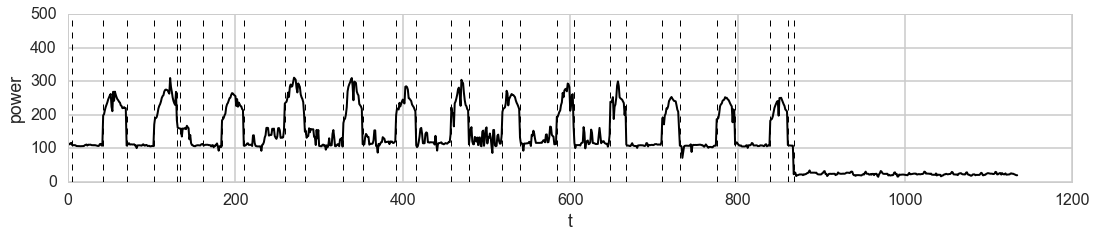

In [446]:
%%time
shapes = [cluster_mean_sort[i] for i in range(6) if i != 2]
shapes_std = [cluster_std_sort[i] for i in range(6) if i != 2]
t, y, cp, result_dict_all = disaggregate_with_shape_0813(t_raw_4_16_19_23, y_raw_4_16_19_23, shapes, shapes_std, [0, 200])
plot_with_cp(y,cp)

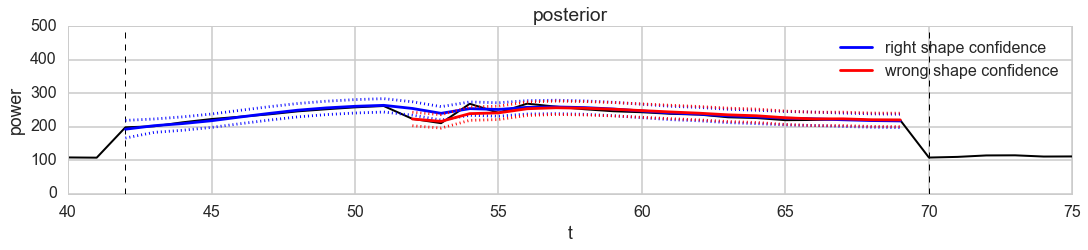

In [447]:
plot_with_cp(y,cp)
plt.xlim([40,75])
plt.plot(range(42, 70), [shapes[1][x-42]+result_dict_all[x]['mu_list_post'][1][x-42] for x in range(42, 70)], 'b', label='right shape confidence')
plt.plot(range(42, 70), [shapes[1][x-42]+result_dict_all[x]['mu_list_post'][1][x-42]+result_dict_all[x]['sigma_list_post'][1][x-42] for x in range(42, 70)],':b')
plt.plot(range(42, 70), [shapes[1][x-42]+result_dict_all[x]['mu_list_post'][1][x-42]-result_dict_all[x]['sigma_list_post'][1][x-42] for x in range(42, 70)],':b')
plt.plot(range(52, 70), [shapes[2][x-52]+result_dict_all[x]['mu_list_post'][2][x-52] for x in range(52, 70)],'r',label='wrong shape confidence')
plt.plot(range(52, 70), [shapes[2][x-52]+result_dict_all[x]['mu_list_post'][2][x-52]+result_dict_all[x]['sigma_list_post'][2][x-52] for x in range(52, 70)], 'r:')
plt.plot(range(52, 70), [shapes[2][x-52]+result_dict_all[x]['mu_list_post'][2][x-52]-result_dict_all[x]['sigma_list_post'][2][x-52] for x in range(52, 70)], 'r:')
plt.legend(loc=1)
plt.title('posterior')

** new problem **

In [448]:
[(i, result_dict_all[i]['i_shape_ml'], i - result_dict_all[i]['best_r'], np.exp(np.max(result_dict_all[i]['prob_list_post']))) for i in range(130, 200)]

[(130, 1, 103, 0.94862207842009971),
 (131, 1, 103, 0.85094232862867381),
 (132, 1, 103, 0.58213104936361526),
 (133, 3, 130, 0.3510440249756655),
 (134, 3, 130, 0.54544796637713255),
 (135, 3, 130, 0.54960505856750497),
 (136, 3, 130, 0.5508583781002151),
 (137, 3, 130, 0.54235388705233234),
 (138, 3, 130, 0.53255731693487274),
 (139, 3, 130, 0.52433280618923639),
 (140, 3, 130, 0.52575530039803942),
 (141, 3, 130, 0.5258829154417981),
 (142, 3, 130, 0.52481212497454122),
 (143, 3, 130, 0.53181930810871847),
 (144, 3, 130, 0.52980655565192913),
 (145, 3, 130, 0.51815744250305307),
 (146, 3, 130, 0.50083627700795907),
 (147, 3, 130, 0.50845246495745811),
 (148, 3, 130, 0.48117364886076869),
 (149, 3, 130, 0.47344827795534877),
 (150, 3, 130, 0.47281290702231377),
 (151, 3, 130, 0.46325106516477177),
 (152, 3, 130, 0.45271073456197192),
 (153, 3, 130, 0.44350302940853353),
 (154, 3, 130, 0.43633013620990868),
 (155, 3, 130, 0.41559393862465571),
 (156, 3, 130, 0.39527398033043371),
 (15

(100, 200)

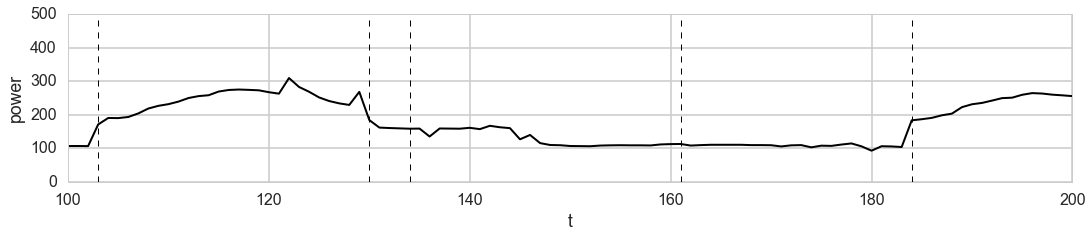

In [449]:
plot_with_cp(y,cp)
plt.xlim([100,200])

In [484]:
def disaggregate_with_shape_0813_2(t, y, shapes, shapes_std, t_range=[0,-1]):
    sigma_init = 20

    t, y = rel_change_filter(t, y, thre=.2)
    n_shapes = len(shapes)

    r_list = [0]
    prior_list = [[np.log(1./n_shapes)]] * n_shapes
    mu_list = [[0]] * n_shapes
    sigma_list =[[sigma_init]] * n_shapes

    # print r_list
    # print prior_list
    # print mu_list
    # print sigma_list

    last_y = 100
    sigma_measurement = 20
    cp_results = []
    cp_counter = create_counter()
    all_cp = []
    r_list_len = []
    
    result_dict_all = {}
    
    for counter in range(len(y)):
        prior_list, mu_list, sigma_list, r_list, most_likely_cp, result_dict = update_prob_0813(y[counter], prior_list, r_list, mu_list, sigma_list, shapes, last_y, sigma_measurement, shapes_std)
        vote(cp_counter, counter, counter-most_likely_cp[1], np.exp(most_likely_cp[2]))
        cp = search_call(cp_counter, 5)
        all_cp.extend(cp)
        all_cp = list(set(all_cp))
        cp_results.append(most_likely_cp)
        r_list_len.append(len(r_list))

        last_y = y[counter]
        
        if counter >= t_range[0] and counter <= t_range[1]:
            result_dict_all[counter] = result_dict

    all_cp = np.sort(all_cp)
    return t, y, all_cp, result_dict_all

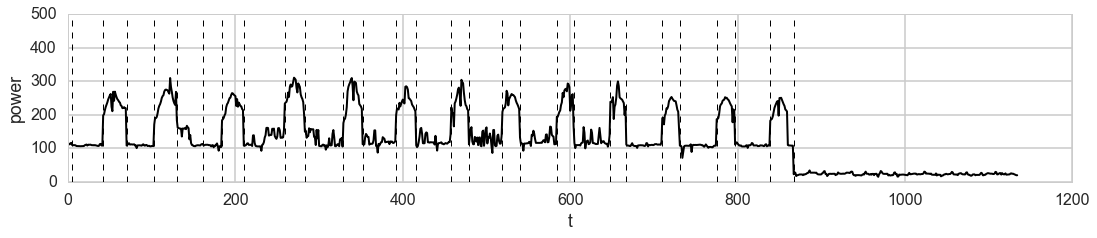

In [485]:
# %%time
shapes = [cluster_mean_sort[i] for i in range(6) if i != 2]
shapes_std = [cluster_std_sort[i] for i in range(6) if i != 2]
t, y, cp, result_dict_all = disaggregate_with_shape_0813_2(t_raw_4_16_19_23, y_raw_4_16_19_23, shapes, shapes_std, [0, 200])
plot_with_cp(y,cp)

** new problem, why ~ 140 there is no change point? **

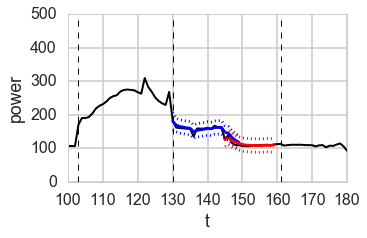

In [486]:
plot_with_cp(y,cp)
# plt.xlim([140, 150])
plt.xlim([100, 180])
plt.gcf().set_size_inches(5, 3)

plt.plot(range(130, 150), [shapes[3][x-130]+result_dict_all[x]['mu_list_post'][3][x-130] for x in range(130, 150)], 'b', label='right shape confidence')
plt.plot(range(130, 150), [shapes[3][x-130]+result_dict_all[x]['mu_list_post'][3][x-130]+result_dict_all[x]['sigma_list_post'][1][x-130] for x in range(130, 150)],':b')
plt.plot(range(130, 150), [shapes[3][x-130]+result_dict_all[x]['mu_list_post'][3][x-130]-result_dict_all[x]['sigma_list_post'][1][x-130] for x in range(130, 150)],':b')

plt.plot(range(145, 160), [shapes[2][x-145]+result_dict_all[x]['mu_list_post'][2][x-145] for x in range(145, 160)], 'r', label='wrong shape confidence')
plt.plot(range(145, 160), [shapes[2][x-145]+result_dict_all[x]['mu_list_post'][2][x-145]+result_dict_all[x]['sigma_list_post'][2][x-145] for x in range(145, 160)], 'r:')
plt.plot(range(145, 160), [shapes[2][x-145]+result_dict_all[x]['mu_list_post'][2][x-145]-result_dict_all[x]['sigma_list_post'][2][x-145] for x in range(145, 160)], 'r:')


** why cp at 161? **

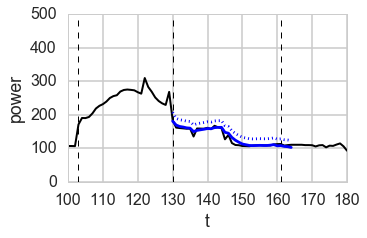

In [487]:
plot_with_cp(y,cp)
# plt.xlim([140, 150])
plt.xlim([100, 180])
plt.gcf().set_size_inches(5, 3)

plt.plot(range(130, 165), [shapes[3][x-130]+result_dict_all[x]['mu_list_post'][3][x-130] for x in range(130, 165)], 'b', label='right shape confidence')
plt.plot(range(130, 165), [shapes[3][x-130]+result_dict_all[x]['mu_list_post'][3][x-130]+result_dict_all[x]['sigma_list_post'][1][x-130] for x in range(130, 165)],':b')
# plt.plot(range(130, 150), [shapes[3][x-130]+result_dict_all[x]['mu_list_post'][3][x-130]-result_dict_all[x]['sigma_list_post'][1][x-130] for x in range(130, 150)],':b')


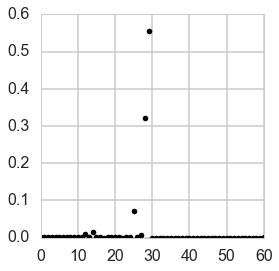

In [488]:
plt.figure(figsize=[4,4])
plt.plot( np.sum(np.exp(np.array(result_dict_all[159]['prob_list_post']).T), axis=1 ), 'k.' )

In [500]:
def update_prob_0813_3(datum, prior_prob, r_list, mu_list, sigma_list, shapes, mu_prior, sigma_measurement, 
                     shape_std_list, flag_print = True, TOL = .99):
    '''
    version update, store all intermediate into a result dict
    set minimal sigma, now sigma also consider variation in shape
    changed TOL to 0.99 by default
    '''
    
    sigma_update_min = 20
    
    n_shape = len(shapes) # the number of possible change points
    n_r = len(r_list) # the number of r(s), r is the distance to the last change point
    shape_len = len(shapes[0])

    
    result_dict = {}
    
    if flag_print:
        result_dict['shape_len'] = shape_len
        result_dict['datum'] = datum
        result_dict['mu_prior'] = mu_prior
#     if len(r_list) != n_shape:
#         raise('the number of r list does not match to the number of shapes')
    if len(prior_prob) != n_shape:
        raise('the number of prior prob does not match to the number of shapes')
    for t in prior_prob:
        if len(t) != n_r:
            print len(t), n_r
            raise('number of r does not match to probs')
    for t in mu_list:
        if len(t) != n_r:
            raise('number of r does not match to mu')
    for t in sigma_list:
        if len(t) != n_r:
            raise('number of r does not match to sigma')
    
    gap_prior = 100.
    min_length_prior = 5
    STORAGE_MAX = 10000 # at a cost of mem, make a look up table for log H and log 1-H
    log_H_list = [np.log(1-1/(gap_prior*100))] * min_length_prior + [np.log(1-1/gap_prior)]*(STORAGE_MAX-min_length_prior) # hazard function, log(1-H)
    log_H_2_list = [np.log(1/(gap_prior*100))] * min_length_prior + [np.log(1/gap_prior)]*(STORAGE_MAX-min_length_prior) # log(H)
    
    if flag_print:
        result_dict['prior_prob'] = prior_prob
        result_dict['r_list'] = r_list
        result_dict['mu_list'] = mu_list
        result_dict['sigma_list'] = sigma_list
        
    # step 1, calculate the new probabilty of prior_prob, considering part of 
    # the possibility will go to new change point
    prior_prob_plus_1 = evolve_prob(prior_prob, r_list, log_H_list)
    prob_change = np.log((1-np.exp(sum_prob(prior_prob_plus_1)))/n_shape)
    prob_update = [[prob_change]+t for t in prior_prob_plus_1]
    if flag_print:
        result_dict['prob_update'] = prob_update
    
    # step 2: update r_list
    r_list_update = [0] + [t+1 for t in r_list]
    if flag_print:
        result_dict['r_list_update'] = r_list_update
    
    # step 3: update u and sigma
    mu_prior = mu_prior
    sigma_prior = 50
    mu_list_update = add_to_front(mu_prior, mu_list)
    sigma_list_update = add_to_front(sigma_prior, sigma_list)
    if flag_print:
        result_dict['mu_list_update'] = mu_list_update
        result_dict['sigma_list_update'] = sigma_list_update
    
    # step 4: predict prob
    mu_list_post = []
    sigma_list_post = []
    prob_list_post = []
    for i_shape in range(n_shape):
        mu_list_post_tmp = []
        sigma_list_post_tmp = []
        prob_list_post_tmp = []
        for i_r in range(n_r+1): # because everything shifted by 1
            r = r_list_update[i_r]
            mu = mu_list_update[i_shape][i_r]
            sigma = sigma_list_update[i_shape][i_r]
            if r < shape_len:
                shape_value = shapes[i_shape][r]
                shape_std = shape_std_list[i_shape][r]
            else:
                shape_value = shapes[i_shape][-1]
                shape_std = shape_std_list[i_shape][-1]
            mu_with_shift = mu + shape_value

            # get measurement error 
            sigma_measurement_2 = np.sqrt( sigma_measurement**2 + shape_std**2 )
            
            # update sigma and mu, note that mu is considered as shift
            mu_update_with_shift = (mu_with_shift*sigma_measurement_2**2+datum*sigma**2)/(sigma_measurement_2**2+sigma**2)
            mu_update = mu_update_with_shift-shape_value
            sigma_update = np.sqrt(sigma_measurement_2**2*sigma**2/(sigma_measurement_2**2+sigma**2))
            sigma_update = sigma_update if sigma_update > sigma_update_min else sigma_update_min
            
            prob = prob_update[i_shape][i_r]
            predict_prob = -((datum-mu_with_shift)/sigma_measurement_2)**2/2.0-np.log(sigma_measurement_2) 
            prob_post = prob + predict_prob
            
            if flag_print:
                if 'update_para' not in result_dict:
                    result_dict['update_para'] = []
                result_dict['update_para'].append({'i_shape':i_shape, 'i_r':i_r, 
                                    'mu': mu, 'sigma': sigma, 'mu_with_shift': mu_with_shift, 
                                    'mu_update_with_shift': mu_update_with_shift, 'mu_update': mu_update, 'sigma_update': sigma_update, 
                                    'prob': prob, 'predict_prob': predict_prob, 'prob_post': prob_post, 
                                    'shape_std': shape_std, 'shape_value': shape_value, 'sigma_measurement_2': sigma_measurement_2
                                   })
            mu_list_post_tmp.append(mu_update)
            sigma_list_post_tmp.append(sigma_update)
            prob_list_post_tmp.append(prob_post)
        mu_list_post.append(mu_list_post_tmp)
        sigma_list_post.append(sigma_list_post_tmp)
        prob_list_post.append(prob_list_post_tmp)
    
    if flag_print:
        result_dict['prob_list_post_after_update'] = prob_list_post

    # truncation
    t = sum_prob(prob_list_post)
    prob_list_post = add_to_all(prob_list_post, -t)
    
    if flag_print:
        result_dict['prob_list_post_after_normalization'] = prob_list_post

    # test if truncation is possible
    cum_pro = np.cumsum( np.sum(np.exp(prob_list_post),axis=0) )
    i_r_max = np.min([i for i, pro in enumerate(cum_pro) if pro > TOL]);
    if flag_print:
        result_dict['current r_max'] = r_list_update[i_r_max]
        result_dict['i_r_max'] = i_r_max
        
    if i_r_max<10:
        i_r_max = len(cum_pro)-1

#     if flag_print:
#         result_dict['cum_pro'] = cum_pro
#         result_dict['mu_list_post'] = mu_list_post
#         result_dict['sigma_list_post'] = sigma_list_post
#         result_dict['prob_list_post'] = prob_list_post
#         result_dict['r_list_update'] = r_list_update
        
    mu_list_post = extract_first_n(mu_list_post, i_r_max+1)
    sigma_list_post = extract_first_n(sigma_list_post, i_r_max+1)
    prob_list_post = extract_first_n(prob_list_post, i_r_max+1)
    r_list_update = [t for i, t in enumerate(r_list_update) if i <= i_r_max]
    if flag_print:
        result_dict['i_r_max'] = i_r_max
        result_dict['total r'] = len(cum_pro)
        result_dict['prob_list_post_after_extract_first_n'] = prob_list_post
        
    # a second round of truncation for flat signals, truncate from the end
    valid_r = []
    if len(r_list_update) > 30:
        r_max = np.max(r_list_update)
        valid_r = [i for i,t in enumerate(r_list_update) if t < 30 or t >= r_max-30]
        mu_list_post = select_from_list(mu_list_post, valid_r)
        sigma_list_post = select_from_list(sigma_list_post, valid_r)
        prob_list_post = select_from_list(prob_list_post, valid_r)
        r_list_update = [r_list_update[i] for i in valid_r]
        
    if flag_print:
        result_dict['prob_list_post_after_second_truncation'] = prob_list_post
        result_dict['prob_list_post_after_second_truncation_valid_r'] = valid_r
        result_dict['prob_list_post_after_second_truncation_r_list_update'] = r_list_update
        
    # find the highest p
    i_shape_ml, i_r_ml = get_max_id(prob_list_post)
    if flag_print:
        result_dict['i_shape_ml'] = i_shape_ml
        result_dict['best_r'] = r_list_update[i_r_ml]
        
    if flag_print:
        result_dict['mu_list_post'] = mu_list_post
        result_dict['sigma_list_post'] = sigma_list_post
        result_dict['prob_list_post'] = prob_list_post
        result_dict['r_list_update_post'] = r_list_update
    
    r_list_update[i_r_ml]
    return prob_list_post, mu_list_post, sigma_list_post, r_list_update, (i_shape_ml, r_list_update[i_r_ml], np.max(prob_list_post)), result_dict

def disaggregate_with_shape_0813_3(t, y, shapes, shapes_std, t_range=[0,-1], flag_print=True):
    sigma_init = 20

    t, y = rel_change_filter(t, y, thre=.2)
    n_shapes = len(shapes)

    r_list = [0]
    prior_list = [[np.log(1./n_shapes)]] * n_shapes
    mu_list = [[0]] * n_shapes
    sigma_list =[[sigma_init]] * n_shapes

    # print r_list
    # print prior_list
    # print mu_list
    # print sigma_list

    last_y = 100
    sigma_measurement = 20
    cp_results = []
    cp_counter = create_counter()
    all_cp = []
    r_list_len = []
    
    result_dict_all = {}
    
    for counter in range(len(y)):
        prior_list, mu_list, sigma_list, r_list, most_likely_cp, result_dict = update_prob_0813_3(y[counter], prior_list, r_list, mu_list, sigma_list, shapes, last_y, sigma_measurement, shapes_std, flag_print=flag_print)
        vote(cp_counter, counter, counter-most_likely_cp[1], np.exp(most_likely_cp[2]))
        cp = search_call(cp_counter, 5)
        all_cp.extend(cp)
        all_cp = list(set(all_cp))
        cp_results.append(most_likely_cp)
        r_list_len.append(len(r_list))

        last_y = y[counter]
        
        if counter >= t_range[0] and counter <= t_range[1]:
            result_dict_all[counter] = result_dict

    all_cp = np.sort(all_cp)
    return t, y, all_cp, result_dict_all

CPU times: user 3.42 s, sys: 38.7 ms, total: 3.46 s
Wall time: 3.44 s


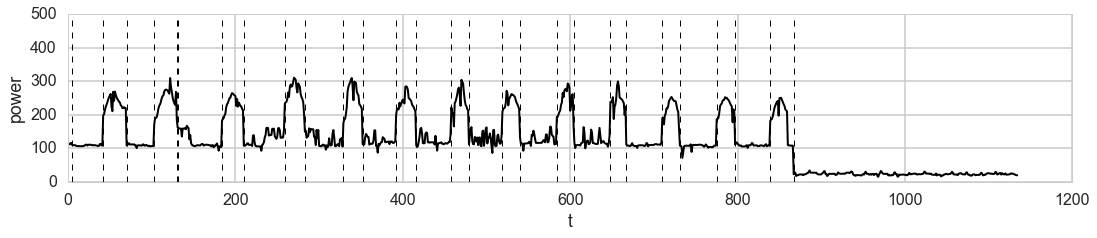

In [502]:
%%time
shapes = [cluster_mean_sort[i] for i in range(6) if i != 2]
shapes_std = [cluster_std_sort[i] for i in range(6) if i != 2]
t, y, cp, result_dict_all = disaggregate_with_shape_0813_3(t_raw_4_16_19_23, y_raw_4_16_19_23, shapes, shapes_std, flag_print=False)
plot_with_cp(y,cp)

## try other data

In [491]:
t_raw_4_16_19_23, y_raw_4_16_19_23 = load_dat('4-16', 19, 23, 'data/IHG/')
t_raw_4_3_7_18, y_raw_4_3_7_18 = load_dat('4-3', 7, 18, 'data/IHG/')
t_raw_4_4_7_18, y_raw_4_4_7_18 = load_dat('4-4', 7, 18, 'data/IHG/')

cp: [0]
CPU times: user 12.8 s, sys: 320 ms, total: 13.2 s
Wall time: 13 s


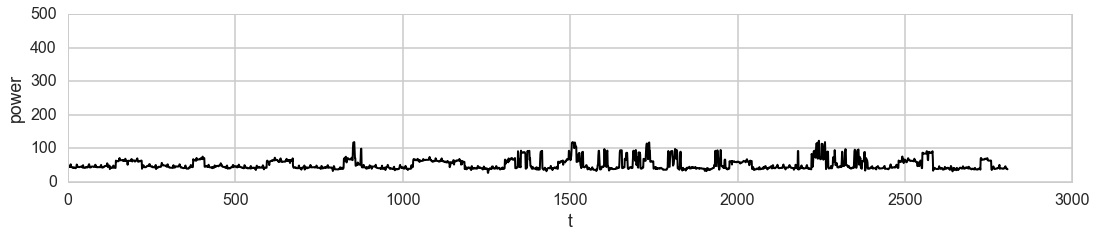

In [504]:
%%time
shapes = [cluster_mean_sort[i] for i in range(6) if i != 2]
shapes_std = [cluster_std_sort[i] for i in range(6) if i != 2]
t, y, cp, result_dict_all = disaggregate_with_shape_0813_3(t_raw_4_4_7_18, y_raw_4_4_7_18, shapes, shapes_std, flag_print=False)
plot_with_cp(y,cp)
print 'cp:', cp

CPU times: user 9.96 s, sys: 231 ms, total: 10.2 s
Wall time: 10.1 s


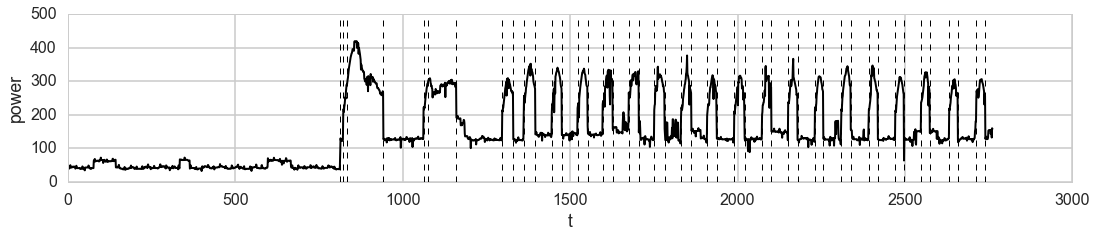

In [505]:
%%time
shapes = [cluster_mean_sort[i] for i in range(6) if i != 2]
shapes_std = [cluster_std_sort[i] for i in range(6) if i != 2]
t, y, cp, result_dict_all = disaggregate_with_shape_0813_3(t_raw_4_3_7_18, y_raw_4_3_7_18, shapes, shapes_std, flag_print=False)
plot_with_cp(y,cp)

cp: [   0  813  822  833  942 1062 1074 1160 1297 1330 1361 1396 1445 1475 1522
 1552 1597 1627 1675 1705 1751 1782 1831 1862 1909 1938 1990 2021 2073 2101
 2151 2179 2231 2256 2309 2338 2391 2419 2471 2497 2548 2574 2632 2658 2713
 2740]


(750, 1000)

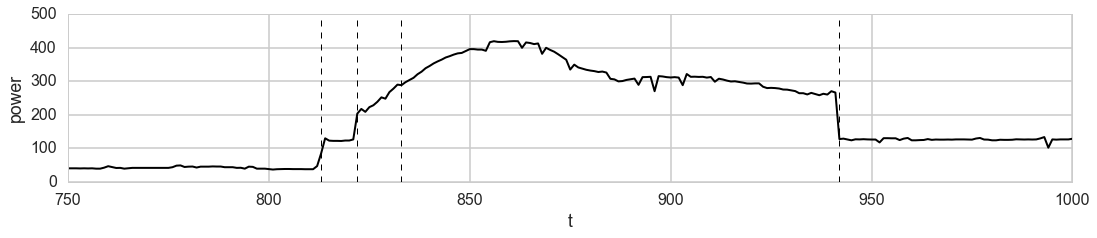

In [507]:
plot_with_cp(y,cp)
print 'cp:', cp
plt.xlim([750, 1000])

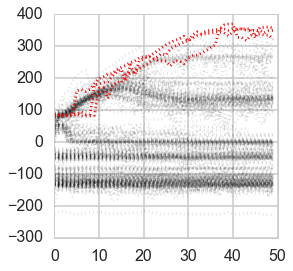

In [527]:
# Add a new shape
all_seg_2_april_50 = extract_first_n( all_seg_2_april, 50)

plt.figure(figsize=[4,4])
plt.plot(np.array(all_seg_2_april_50).T, 'k:', alpha=.1)
get_max_id( all_seg_2_april_50 )

tmp = [i for i,dat in enumerate(all_seg_2_april_50) if dat[40] > 320]
plt.plot(np.array( [all_seg_2_april_50[i] for i in tmp] ).T, 'r:')
high_power_shape = np.mean([all_seg_2_april_50[i] for i in tmp], axis=0)
high_power_shape_std = cluster_std_sort[0]


(750, 1000)

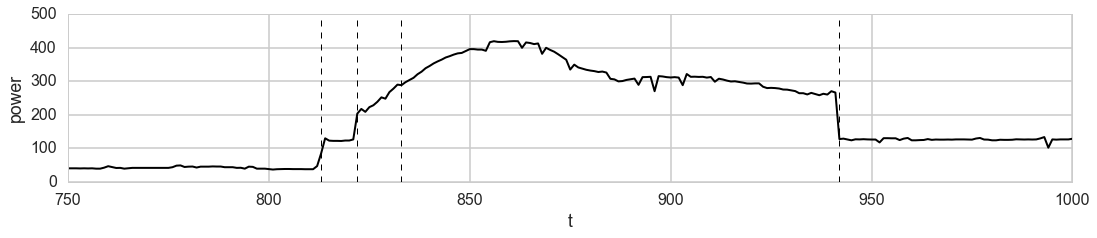

In [536]:
shapes = [cluster_mean_sort[i] for i in range(6) if i != 2]
shapes_std = [cluster_std_sort[i] for i in range(6) if i != 2]

shapes.append(high_power_shape)
shapes_std.append(high_power_shape_std)

t, y, cp, result_dict_all = disaggregate_with_shape_0813_3(t_raw_4_3_7_18, y_raw_4_3_7_18, shapes, shapes_std, t_range=[810, 950])
plot_with_cp(y,cp)
plt.xlim([750, 1000])

(810, 900)

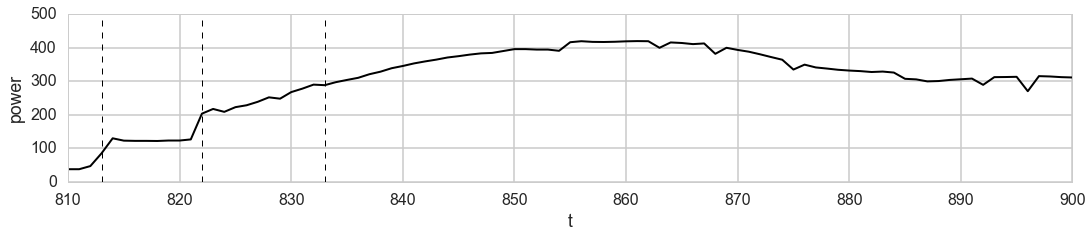

In [537]:
plot_with_cp(y,cp)
plt.xlim([810, 900])

In [554]:
print result_dict_all[822].keys()

print result_dict_all[822]['datum']
print result_dict_all[822]['i_shape_ml'], result_dict_all[822]['best_r']
print [t for t in result_dict_all[822]['update_para'] if t['i_shape']==5 and t['i_r'] == 0]

print result_dict_all[823]['datum']
print result_dict_all[823]['i_shape_ml'], result_dict_all[823]['best_r']
print [t for t in result_dict_all[823]['update_para'] if t['i_shape']==5 and t['i_r'] == 1]


['prob_list_post_after_second_truncation_r_list_update', 'datum', 'prob_list_post_after_normalization', 'sigma_list_update', 'prob_update', 'sigma_list_post', 'total r', 'prob_list_post_after_update', 'r_list_update_post', 'i_r_max', 'update_para', 'prob_list_post', 'mu_list', 'r_list', 'mu_list_update', 'r_list_update', 'prob_list_post_after_second_truncation', 'prior_prob', 'mu_prior', 'best_r', 'i_shape_ml', 'prob_list_post_after_second_truncation_valid_r', 'mu_list_post', 'prob_list_post_after_extract_first_n', 'shape_len', 'current r_max', 'sigma_list']
203.0
5 9
[{'sigma_update': 25.121466952993039, 'i_r': 0, 'shape_value': 83.222222222222229, 'mu_update_with_shift': 204.57070816465503, 'predict_prob': -3.3921207441094161, 'shape_std': 21.075860198920957, 'i_shape': 5, 'prob_post': -9.7721117061549414, 'mu_with_shift': 209.22222222222223, 'mu': 126.0, 'sigma_measurement_2': 29.054980349751752, 'mu_update': 121.3484859424328, 'sigma': 50, 'prob': -6.3799909620455253}]
217.0
5 10
[

(750, 1000)

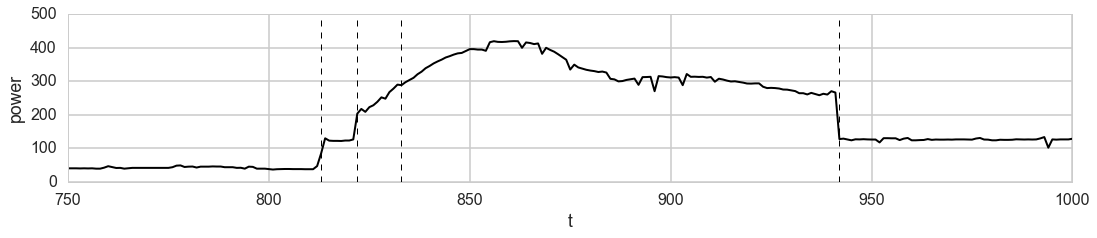

In [556]:
shapes = [cluster_mean_sort[i] for i in range(6) if i != 2]
shapes_std = [cluster_std_sort[i] for i in range(6) if i != 2]

steady_power = [100] * 50
steady_power_std = cluster_std_sort[0]

shapes.append(high_power_shape)
shapes_std.append(high_power_shape_std)

shapes.append(steady_power)
shapes_std.append(steady_power_std)

t, y, cp, result_dict_all = disaggregate_with_shape_0813_3(t_raw_4_3_7_18, y_raw_4_3_7_18, shapes, shapes_std, t_range=[810, 950])
plot_with_cp(y,cp)
plt.xlim([750, 1000])

(800, 850)

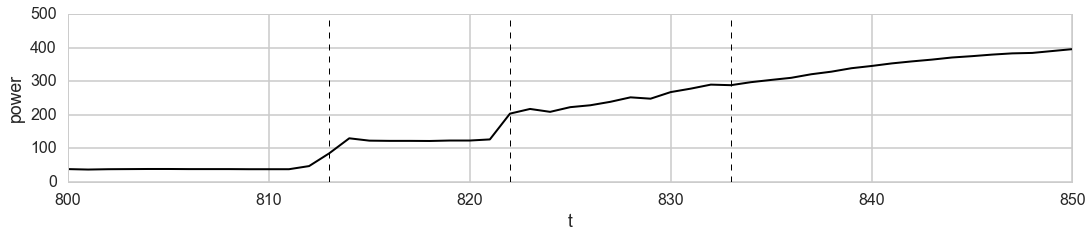

In [557]:
plot_with_cp(y,cp)
plt.xlim([800, 850])

In [558]:
print result_dict_all[813].keys()

print result_dict_all[813]['datum']
print result_dict_all[813]['i_shape_ml'], result_dict_all[822]['best_r']
print [t for t in result_dict_all[813]['update_para'] if t['i_shape']==6 and t['i_r'] == 0]

print result_dict_all[813]['datum']
print result_dict_all[813]['i_shape_ml'], result_dict_all[823]['best_r']
print [t for t in result_dict_all[813]['update_para'] if t['i_shape']==6 and t['i_r'] == 1]


['prob_list_post_after_second_truncation_r_list_update', 'datum', 'prob_list_post_after_normalization', 'sigma_list_update', 'prob_update', 'sigma_list_post', 'total r', 'prob_list_post_after_update', 'r_list_update_post', 'i_r_max', 'update_para', 'prob_list_post', 'mu_list', 'r_list', 'mu_list_update', 'r_list_update', 'prob_list_post_after_second_truncation', 'prior_prob', 'mu_prior', 'best_r', 'i_shape_ml', 'prob_list_post_after_second_truncation_valid_r', 'mu_list_post', 'prob_list_post_after_extract_first_n', 'shape_len', 'current r_max', 'sigma_list']
84.3333333333
2 9
[{'sigma_update': 25.121466952993039, 'i_r': 0, 'shape_value': 100, 'mu_update_with_shift': 99.984318259717313, 'predict_prob': -5.6459234794149546, 'shape_std': 21.075860198920957, 'i_shape': 6, 'prob_post': -12.142507410654066, 'mu_with_shift': 146.33333333333334, 'mu': 46.333333333333336, 'sigma_measurement_2': 29.054980349751752, 'mu_update': -0.015681740282687429, 'sigma': 50, 'prob': -6.4965839312391118}]
84

In [613]:
import datetime

def read_dat(date, h_start, h_end, folder_path):
    dat = []
    for h in range(h_start, h_end):
        try:
            file_name = '%d-%d-%d.csv' % (date.month, date.day, h)
            file_path = path.join(folder_path, file_name)
            tmp = pd.read_csv( file_path )
            dat.extend( [t[1]/3 for t in tmp.values] )
        except:
            print '%s failed' % file_path
    return dat



In [611]:
date_start = datetime.date(2016,4,1)
date_end = datetime.date(2016,8,1)
date_current = date_start
while date_current<date_end:
    try:
        date = str(date_current.month) + '-' + str(date_current.day)

        y = read_dat(date_current, 0, 24, folder_path='new_data/IHG')
        t = range(len(y))
        
        t_2, y_2 = rel_change_filter(t,y,thre=.2)
        t_2 = [t/240. for t in t_2]

        fig = plt.figure(figsize=[18,3])
        plt.plot(t_2, y_2, 'k.-', linewidth=1, markersize=3)
        plt.ylim([0,500])
        plt.xlim([0,24])
        plt.title(date)
        
        fig.savefig('results/meter_1_'+date+'.png')
        plt.close(fig)
    except:
        pass
    date_current += datetime.timedelta(1)

new_data/IHG/4-28-4.csv failed
new_data/IHG/5-6-8.csv failed
new_data/IHG/5-8-9.csv failed
new_data/IHG/5-20-19.csv failed
new_data/IHG/5-20-20.csv failed
new_data/IHG/5-20-21.csv failed
new_data/IHG/5-20-22.csv failed
new_data/IHG/5-20-23.csv failed
new_data/IHG/5-21-0.csv failed
new_data/IHG/5-21-1.csv failed
new_data/IHG/5-21-2.csv failed
new_data/IHG/5-21-3.csv failed
new_data/IHG/5-21-4.csv failed
new_data/IHG/5-21-5.csv failed
new_data/IHG/5-21-6.csv failed
new_data/IHG/5-21-7.csv failed
new_data/IHG/5-21-8.csv failed
new_data/IHG/5-21-9.csv failed
new_data/IHG/5-21-10.csv failed
new_data/IHG/5-21-11.csv failed
new_data/IHG/5-21-12.csv failed
new_data/IHG/5-21-13.csv failed
new_data/IHG/5-21-14.csv failed
new_data/IHG/5-21-15.csv failed
new_data/IHG/5-21-16.csv failed
new_data/IHG/5-21-17.csv failed
new_data/IHG/5-21-18.csv failed
new_data/IHG/6-16-18.csv failed
new_data/IHG/7-18-18.csv failed
new_data/IHG/7-18-19.csv failed
new_data/IHG/7-18-20.csv failed
new_data/IHG/7-18-21.cs

In [612]:
#     date_current = date_start

#     all_seg = []
#     all_seg_2 = []

#     while date_current < date_end:
#         date = str(date_current.month) + '-' + str(date_current.day)
#         print 'reading', date, Hstart, Hend
        
#         t, y = load_dat(date, Hstart, Hend)
#         t, y = filter_dat(t, y)
#         [dat_seg, changepoint] = disaggregate(y)
#         dat_seg_new = normalize_by_last_n_point(dat_seg)
        
#         all_seg.append(dat_seg_new)
#         all_seg_2.extend(dat_seg_new)
        
#         date_current += datetime.timedelta(1)
#     return all_seg, all_seg_2

def read_dat(date, h_start, h_end, folder_path):
    dat = []
    for h in range(h_start, h_end):
        try:
            file_name = '%d-%d-%d.csv' % (date.month, date.day, h)
            file_path = path.join(folder_path, file_name)
            tmp = pd.read_csv( file_path )
            dat.extend( [t[1]/3 for t in tmp.values] )
        except:
            print '%s failed' % file_path
    return dat

date_start = datetime.date(2016,4,1)
date_end = datetime.date(2016,8,1)
date_current = date_start
while date_current<date_end:
    try:
        date = str(date_current.month) + '-' + str(date_current.day)

        y = read_dat(date_current, 0, 24, folder_path='new_data/IHG_2')
        t = range(len(y))
        
        t_2, y_2 = rel_change_filter(t,y,thre=.2)
        t_2 = [t/240. for t in t_2]

        fig = plt.figure(figsize=[18,3])
        plt.plot(t_2, y_2, 'k.-', linewidth=1, markersize=3)
        plt.ylim([0,500])
        plt.xlim([0,24])
        plt.title(date)
        
        fig.savefig('results/meter_2_'+date+'.png')
        plt.close(fig)
    except:
        pass
    date_current += datetime.timedelta(1)

new_data/IHG_2/4-17-20.csv failed
new_data/IHG_2/4-24-7.csv failed
new_data/IHG_2/4-24-10.csv failed
new_data/IHG_2/4-27-13.csv failed
new_data/IHG_2/5-7-3.csv failed
new_data/IHG_2/5-7-20.csv failed
new_data/IHG_2/5-7-22.csv failed
new_data/IHG_2/5-16-6.csv failed
new_data/IHG_2/5-16-7.csv failed
new_data/IHG_2/5-20-19.csv failed
new_data/IHG_2/5-20-20.csv failed
new_data/IHG_2/5-20-21.csv failed
new_data/IHG_2/5-20-22.csv failed
new_data/IHG_2/5-20-23.csv failed
new_data/IHG_2/5-21-0.csv failed
new_data/IHG_2/5-21-1.csv failed
new_data/IHG_2/5-21-2.csv failed
new_data/IHG_2/5-21-3.csv failed
new_data/IHG_2/5-21-4.csv failed
new_data/IHG_2/5-21-5.csv failed
new_data/IHG_2/5-21-6.csv failed
new_data/IHG_2/5-21-7.csv failed
new_data/IHG_2/5-21-8.csv failed
new_data/IHG_2/5-21-9.csv failed
new_data/IHG_2/5-21-10.csv failed
new_data/IHG_2/5-21-11.csv failed
new_data/IHG_2/5-21-12.csv failed
new_data/IHG_2/5-21-13.csv failed
new_data/IHG_2/5-21-14.csv failed
new_data/IHG_2/5-21-15.csv fail

In [620]:
%%time
shapes = [cluster_mean_sort[i] for i in range(6) if i != 2]
shapes_std = [cluster_std_sort[i] for i in range(6) if i != 2]

date_start = datetime.date(2016,4,1)
date_end = datetime.date(2016,8,1)
# date_end = datetime.date(2016,4,3)
date_current = date_start
while date_current<date_end:
    try:
        date = str(date_current.month) + '-' + str(date_current.day)
        print date

        y = read_dat(date_current, 0, 24, folder_path='new_data/IHG')
        t = range(len(y))
        
        t_2, y_2 = rel_change_filter(t,y,thre=.2)
#         t_2 = [t/240. for t in t_2]

        t, y, cp, result_dict_all = disaggregate_with_shape_0813_3(t_2, y_2, shapes, shapes_std, flag_print=False)
        
#         fig = plt.figure(figsize=[18,3])
        plot_with_cp(y,cp)
        plt.ylim([0,500])
        plt.title(date)
        
        fig = plt.gcf()
        fig.set_size_inches(18, 3)

        fig.savefig('results/seg_0813_meter_1_'+date+'.png')
        plt.close(fig)
    except:
        pass
    date_current += datetime.timedelta(1)

4-1
4-2
4-3
4-4
4-5
4-6
4-7
4-8
4-9
4-10
4-11
4-12
4-13
4-14
4-15
4-16
4-17
4-18
4-19
4-20
4-21
4-22
4-23
4-24
4-25
4-26
4-27
4-28
new_data/IHG/4-28-4.csv failed
4-29
4-30
5-1
5-2
5-3
5-4
5-5
5-6
new_data/IHG/5-6-8.csv failed
5-7
5-8
new_data/IHG/5-8-9.csv failed
5-9
5-10
5-11
5-12
5-13
5-14
5-15
5-16
5-17
5-18
5-19
5-20
new_data/IHG/5-20-19.csv failed
new_data/IHG/5-20-20.csv failed
new_data/IHG/5-20-21.csv failed
new_data/IHG/5-20-22.csv failed
new_data/IHG/5-20-23.csv failed
5-21
new_data/IHG/5-21-0.csv failed
new_data/IHG/5-21-1.csv failed
new_data/IHG/5-21-2.csv failed
new_data/IHG/5-21-3.csv failed
new_data/IHG/5-21-4.csv failed
new_data/IHG/5-21-5.csv failed
new_data/IHG/5-21-6.csv failed
new_data/IHG/5-21-7.csv failed
new_data/IHG/5-21-8.csv failed
new_data/IHG/5-21-9.csv failed
new_data/IHG/5-21-10.csv failed
new_data/IHG/5-21-11.csv failed
new_data/IHG/5-21-12.csv failed
new_data/IHG/5-21-13.csv failed
new_data/IHG/5-21-14.csv failed
new_data/IHG/5-21-15.csv failed
new_data/I

In [ ]:
1